# TRIAL NOTEBOOK

## Import Libraries

In [2]:
import os
import time
import pandas as pd
import nltk
import numpy as np

## Download NLTK Resources

In [3]:
# !mkdir -p ~/nltk_data
# !git clone https://github.com/nltk/nltk_data.git
# !mv nltk_data/packages/* ~/nltk_data/
# !rm -rf nltk_data

# # Unzip punkt
# !WORK_DIR=$(pwd)
# !cd ~/nltk_data/tokenizers/
# !unzip punkt.zip
# !rm punkt.zip

# !cd $WORK_DIR

## Import helper functions

In [4]:
from utils import load_sessions, read_session, read_file
from operations import build_text

## Read File and Load Events

In [5]:
events = read_file("7c1e066d0c9c4901921cab117a0b7e73.jsonl")
# events = read_file("0a8e182a20df447db4846b1223c619b5.jsonl")

Successfully read 1504 events in a writing session from ./coauthor-v1.0/7c1e066d0c9c4901921cab117a0b7e73.jsonl


## Build Text Buffer

In [6]:
text_buffer = []

In [7]:
for event in events:
    buffer = build_text(text_buffer, event)
    text_buffer.append(buffer)

## Initialize DataFrame

In [8]:
df = pd.DataFrame()

In [9]:
df["text_buffer"] = text_buffer
df["events"] = events

In [10]:
df.head()

,text_buffer,events
0,"A woman has been dating guy after guy, but it ...","{'eventName': 'system-initialize', 'eventSourc..."
1,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u..."
2,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u..."
3,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-get', 'eventSource':..."
4,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-open', 'eventSource'..."


## Extract Sentences

In [11]:
# Add sentences

sentence_buffer = []
num_sentences = []

for text in df["text_buffer"]:
    sentences = nltk.tokenize.sent_tokenize(text)
    sentence_buffer.append(sentences)
    num_sentences.append(len(sentences))

In [12]:
df["sentences"] = sentence_buffer
df["num_sentences"] = num_sentences

In [13]:
df.head()

,text_buffer,events,sentences,num_sentences
0,"A woman has been dating guy after guy, but it ...","{'eventName': 'system-initialize', 'eventSourc...","[A woman has been dating guy after guy, but it...",2
1,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u...","[A woman has been dating guy after guy, but it...",2
2,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u...","[A woman has been dating guy after guy, but it...",2
3,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-get', 'eventSource':...","[A woman has been dating guy after guy, but it...",2
4,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-open', 'eventSource'...","[A woman has been dating guy after guy, but it...",2


## Extract Event Names

In [14]:
df["event_name"] = df["events"].apply(lambda x: x["eventName"])

In [15]:
df.head()

,text_buffer,events,sentences,num_sentences,event_name
0,"A woman has been dating guy after guy, but it ...","{'eventName': 'system-initialize', 'eventSourc...","[A woman has been dating guy after guy, but it...",2,system-initialize
1,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u...","[A woman has been dating guy after guy, but it...",2,text-insert
2,"A woman has been dating guy after guy, but it ...","{'eventName': 'text-insert', 'eventSource': 'u...","[A woman has been dating guy after guy, but it...",2,text-insert
3,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-get', 'eventSource':...","[A woman has been dating guy after guy, but it...",2,suggestion-get
4,"A woman has been dating guy after guy, but it ...","{'eventName': 'suggestion-open', 'eventSource'...","[A woman has been dating guy after guy, but it...",2,suggestion-open


## Correct Number of Sentences in accordance to Event Name

In [16]:
df = df.groupby("num_sentences", group_keys=True).apply(lambda x: x)
df = df.sort_index()

In [17]:
df.head()

text_buffer  \
num_sentences                                                        
2             0  A woman has been dating guy after guy, but it ...   
              1  A woman has been dating guy after guy, but it ...   
              2  A woman has been dating guy after guy, but it ...   
              3  A woman has been dating guy after guy, but it ...   
              4  A woman has been dating guy after guy, but it ...   

                                                            events  \
num_sentences                                                        
2             0  {'eventName': 'system-initialize', 'eventSourc...   
              1  {'eventName': 'text-insert', 'eventSource': 'u...   
              2  {'eventName': 'text-insert', 'eventSource': 'u...   
              3  {'eventName': 'suggestion-get', 'eventSource':...   
              4  {'eventName': 'suggestion-open', 'eventSource'...   

                                                         sentences  \
num_sentences                                                        
2             0  [A woman has been dating guy after guy, but it...   
              1  [A woman has been dating guy after guy, but it...   
              2  [A woman has been dating guy after guy, but it...   
              3  [A woman has been dating guy after guy, but it...   
              4  [A woman has been dating guy after guy, but it...   

                 num_sentences         event_name  
num_sentences                                      
2             0              2  system-initialize  
              1              2        text-insert  
              2              2        text-insert  
              3              2     suggestion-get  
              4              2    suggestion-open

In [18]:
num_sentences = np.array(df["num_sentences"])
event_names = np.array(df["event_name"])

In [19]:
start_idx = 0
select_flag = False

for idx, event in enumerate(event_names):
    if event == "suggestion-get":
        start_idx = idx
    if event == "suggestion-select":
        select_flag = True
    if select_flag and event == "text-insert":
        if num_sentences[start_idx] == num_sentences[idx]:
            end_idx = idx + 1
        elif num_sentences[start_idx] < num_sentences[idx]:
            end_idx = idx
        for i in range(start_idx, end_idx):
            num_sentences[i] += 1
        select_flag = False

In [20]:
# for idx, _ in enumerate(event_names):
#     print(num_sentences[idx], event_names[idx])

In [21]:
df["num_sentences"] = num_sentences

## Compute Sentence and Event Sequence

In [22]:
# np.unique(df["num_sentences"])

In [23]:
def compute_seq(events):
    
    # Remove suggestion-open, suggestion-hover
    events = np.delete(events, np.where(events == "suggestion-open"))
    events = np.delete(events, np.where(events == "suggestion-hover"))
    
    # Remove text-insert after suggestion-select
    select_flag = False
    new_events = []
    for idx, event in enumerate(events):
        if event == "suggestion-select":
            select_flag = True
        if event == "text-insert" and select_flag:
            select_flag = False
            continue
        new_events.append(event)
    events = np.array(new_events)
    
    # Identify GPT-3 modifications
    select_flag = False
    new_events = []
    for idx, event in enumerate(events):
        if event == "suggestion-select":
            select_flag = True
        if event == "text-insert":
            select_flag = False
        if (event == "cursor-backward" or event == "cursor-select" or event == "text-delete") and select_flag:
            select_flag = False
            event = "gpt3-modify"
        new_events.append(event)
    events = np.array(new_events)
    
    # Remove cursor-forward, cursor-backward, cursor-select
    events = np.delete(events, np.where(events == "cursor-forward"))
    events = np.delete(events, np.where(events == "cursor-backward"))
    events = np.delete(events, np.where(events == "cursor-select"))
    
    # Remove text-delete
    events = np.delete(events, np.where(events == "text-delete"))
    
    # Remove suggestion-close
    events = np.delete(events, np.where(events == "suggestion-close"))
    
    # Identify GTP-3 calls
    events = events.tolist()
    start_idx = 0
    api_flag = False
    pop_idx = []
    for idx, event in enumerate(events):
        if event == "suggestion-get":
            start_idx = idx
            api_flag = True
        if event == "suggestion-select" and api_flag:
            api_flag = False
            for i in range(start_idx, idx):
                pop_idx.append(i)
    events = np.array(events)
    events = np.delete(events, pop_idx)
    
    # Group together text-inserts
    new_events = []
    temp = []
    for event in events:
        if event == "text-insert":
            temp.append(event)
        else:
            if len(temp) != 0:
                new_events.append("text-insert")
            new_events.append(event)
            temp = []
    if len(temp) != 0:
        new_events.append("text-insert")
    events = np.array(new_events)
    
    # Rename sequences
    seq_name_dict = {
        "system-initialize": "prompt",
        "text-insert": "user",
        "suggestion-get": "empty-call",
        "suggestion-select": "gpt3-call",
        "gpt3-modify": "modify-gpt3",
    }
    new_events = [seq_name_dict[event] for event in events]
    events = np.array(new_events)
    
    return events

In [24]:
for num in np.unique(df["num_sentences"]):
    sent = np.array(df[df["num_sentences"] == num]["text_buffer"])[-1]
    event_seq = np.array(df[df["num_sentences"] == num]["event_name"])
    print(num, compute_seq(event_seq))

2 ['prompt' 'user' 'empty-call' 'empty-call' 'empty-call']
3 ['user']
4 ['gpt3-call' 'user']
5 ['gpt3-call' 'user']
6 ['gpt3-call' 'user']
7 ['gpt3-call']
8 ['gpt3-call']
9 ['gpt3-call' 'user']
10 ['gpt3-call' 'modify-gpt3' 'user' 'empty-call' 'empty-call']
11 ['user']
12 ['gpt3-call' 'user']
13 ['gpt3-call' 'gpt3-call' 'modify-gpt3' 'user']
14 ['user']
15 ['gpt3-call' 'user']
16 ['gpt3-call' 'user']
17 ['gpt3-call']
18 ['gpt3-call' 'user' 'empty-call' 'user']
19 ['gpt3-call' 'modify-gpt3' 'user']
20 ['user']
21 ['user']
22 ['gpt3-call']
23 ['gpt3-call' 'user' 'empty-call' 'user']
24 ['user']
25 ['gpt3-call' 'user']
26 ['gpt3-call' 'user']
27 ['gpt3-call' 'modify-gpt3' 'user']
28 ['gpt3-call' 'user']
29 ['gpt3-call' 'modify-gpt3']
30 ['gpt3-call' 'user']
31 ['gpt3-call' 'empty-call' 'modify-gpt3' 'user']
32 ['gpt3-call' 'modify-gpt3' 'user']
33 ['gpt3-call']
34 ['user']
35 ['gpt3-call' 'user']
36 ['user' 'empty-call' 'user']
37 ['gpt3-call' 'user']
38 ['user' 'empty-call' 'user']
39 ['

## Generate Graph

In [27]:
from PIL import Image, ImageDraw, ImageFont
import math

In [28]:
image = Image.new("RGB", (600, 4500), "white")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

margin = 25
circle_size = 50
sentence_margin = 80
line_size = 30

In [29]:
def user_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + 80 * x
    y_start = margin + 80 * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = (100, 255, 100, 255), outline ='black')

def text(text, y):
    y -= 1
    x_start = margin
    y_start = margin + (circle_size*2/5) + 80 * y
    draw.text((x_start,y_start), text, fill='black', font=font)


def gpt_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + 80 * x
    y_start = margin + 80 * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = "red", outline ='black')


def prompt_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + 80 * x
    y_start = margin + 80 * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = "black", outline ='black')
    

def modified_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + 80 * x
    y_start = margin + 80 * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = "yellow", outline ='black')
    

def empty_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + 80 * x
    y_start = margin + 80 * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = "white", outline ='black')
    

def suggestion_open(x, y):
    x -= 1
    y -= 1
    x_start = margin + circle_size + 80 * x
    y_start = margin + (circle_size/2) + 80 * y
    draw.line([(x_start, y_start),
              (x_start+line_size, y_start)], fill='red', width=3)

def user_change(x, y):
    x -= 1
    y -= 1
    x_start = margin + circle_size + 80 * x
    y_start = margin + (circle_size/2) + 80 * y
    draw.line([(x_start, y_start),
              (x_start+line_size, y_start)], fill= (100, 255, 100, 255), width=3)

In [30]:
for idx, num in enumerate(np.unique(df["num_sentences"])):
    event_seq = np.array(df[df["num_sentences"] == num]["event_name"])
    image_text = "Sentence " + str(idx+1)
    text(image_text, idx+1)
    for i, op in enumerate(compute_seq(event_seq)):
        if op == "gpt3-call":
            if i != 0:
                suggestion_open(i+1, idx+1)
            gpt_circle(i+1, idx+1)
        if op == "user":
            if i != 0:
                user_change(i+1, idx+1)
            user_circle(i+1, idx+1)
        if op == "prompt":
            prompt_circle(i+1, idx+1)
        if op == "modify-gpt3":
            if i != 0:
                user_change(i+1, idx+1)
            modified_circle(i+1, idx+1)
        if op == "empty-call":
            if i != 0:
                suggestion_open(i+1, idx+1)
            empty_circle(i+1, idx+1)

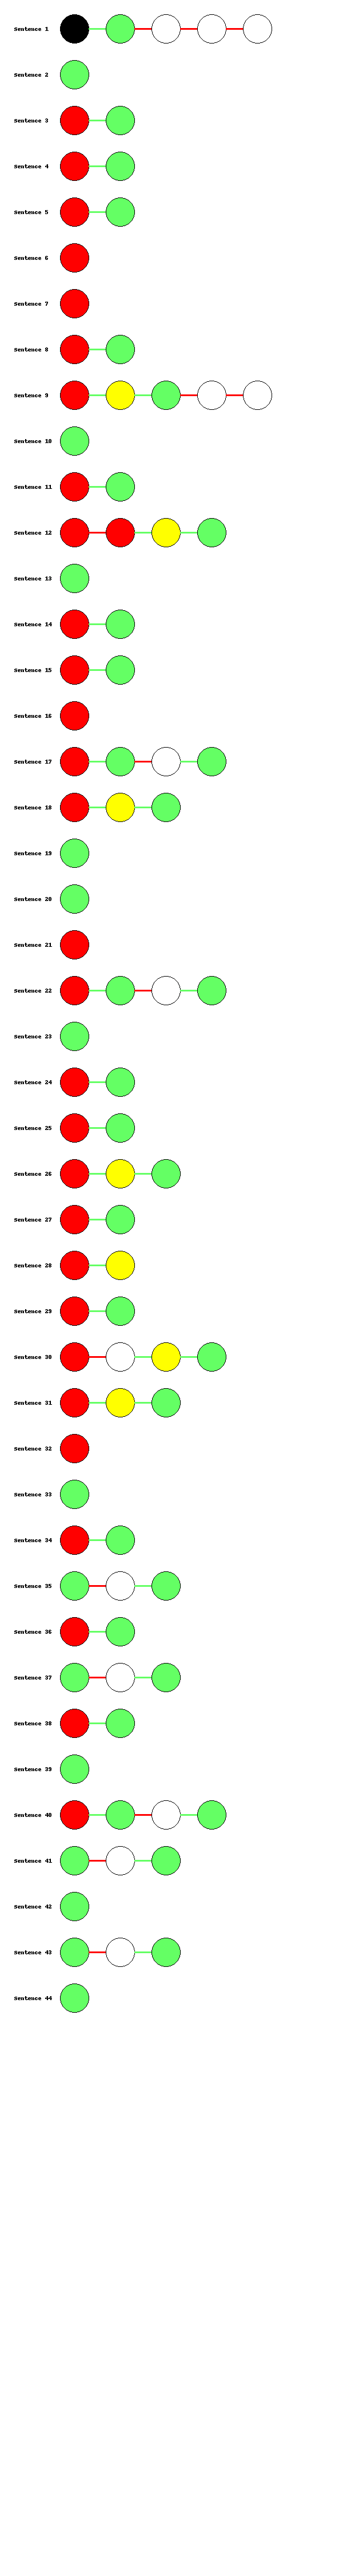

In [31]:
display(image)

In [32]:
# LEGEND: CIRCLES
# Prompt     -> black
# GPT-3      -> red (change color; shape triangle)
# User       -> green (change color; shape rectangle)
# Empty call -> white
# Modify     -> yellow

# LEGEND: LINES
# API Call    -> red
# User Edits  -> green (dashed line)

In [33]:
# https://www.color-blindness.com/coblis-color-blindness-simulator/